# IEEE 2019 - XGBoost - Adversarial

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, warnings, random, datetime, time
import pickle
#from knockknock import telegram_sender
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

import math
warnings.filterwarnings('ignore')
%matplotlib inline

# Pandas display format
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)

In [0]:
# Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# Memory Reducer
def memory_usage_mb(df, *args, **kwargs):
    """Dataframe memory usage in MB. """
    return df.memory_usage(*args, **kwargs).sum() / 1024**2

def reduce_mem_usage(df, deep=True, verbose=False, categories=False):
    # All types that we want to change for "lighter" ones.
    # int8 and float16 are not include because we cannot reduce
    # those data types.
    # float32 is not include because float16 has too low precision.
    numeric2reduce = ["int16", "int32", "int64", "float64"]
    start_mem = 0
    start_mem = memory_usage_mb(df, deep=deep)

    for col, col_type in df.dtypes.iteritems():
        best_type = None
        if categories:
            if col_type == "object":
                df[col] = df[col].astype("category")
                best_type = "category"
        elif col_type in numeric2reduce:
            downcast = "integer" if "int" in str(col_type) else "float"
            df[col] = pd.to_numeric(df[col], downcast=downcast)
            best_type = df[col].dtype.name
        # Log the conversion performed.
        if verbose and best_type is not None and best_type != str(col_type):
            print(f"Column '{col}' converted from {col_type} to {best_type}")

    end_mem = memory_usage_mb(df, deep=deep)
    diff_mem = start_mem - end_mem
    percent_mem = 100 * diff_mem / start_mem
    print(f"Memory usage decreased from"
          f" {start_mem:.2f}MB to {end_mem:.2f}MB"
          f" ({diff_mem:.2f}MB, {percent_mem:.2f}% reduction)")
    
    return df

In [0]:
# Custom Focal Loss

def robust_pow(num_base, num_pow):
    # numpy does not permit negative numbers to fractional power
    # use this to perform the power algorithmic

    return np.sign(num_base) * (np.abs(num_base)) ** (num_pow)

def focal_binary_object(y_pred, dtrain):
    gamma_indct = 2.0
    # retrieve data from dtrain matrix
    label = dtrain.get_label()
    # compute the prediction with sigmoid
    sigmoid_pred = 1.0 / (1.0 + np.exp(-y_pred))
    # gradient
    # complex gradient with different parts
    g1 = sigmoid_pred * (1 - sigmoid_pred)
    g2 = label + ((-1) ** label) * sigmoid_pred
    g3 = sigmoid_pred + label - 1
    g4 = 1 - label - ((-1) ** label) * sigmoid_pred
    g5 = label + ((-1) ** label) * sigmoid_pred
    # combine the gradient
    grad = gamma_indct * g3 * robust_pow(g2, gamma_indct) * np.log(g4 + 1e-9) + \
           ((-1) ** label) * robust_pow(g5, (gamma_indct + 1))
    # combine the gradient parts to get hessian components
    hess_1 = robust_pow(g2, gamma_indct) + \
             gamma_indct * ((-1) ** label) * g3 * robust_pow(g2, (gamma_indct - 1))
    hess_2 = ((-1) ** label) * g3 * robust_pow(g2, gamma_indct) / g4
    # get the final 2nd order derivative
    hess = ((hess_1 * np.log(g4 + 1e-9) - hess_2) * gamma_indct +
            (gamma_indct + 1) * robust_pow(g5, gamma_indct)) * g1

    return grad, hess

In [0]:
# Vars

SEED = 42
seed_everything(SEED)
LOCAL_TEST = False
TARGET = 'isFraud'
PREDICT = True

In [0]:
# DATA LOAD

print('Load Data')
train_df = pd.read_pickle('../content/gdrive/My Drive/IEEE fraud Kaggle 2019/train_full_feat.pkl')

if LOCAL_TEST:
    test_df = train_df[train_df['DT_M']==train_df['DT_M'].max()].reset_index(drop=True)
    train_df = train_df[train_df['DT_M']<(train_df['DT_M'].max()-1)].reset_index(drop=True)    
else:
    test_df = pd.read_pickle('../content/gdrive/My Drive/IEEE fraud Kaggle 2019/test_full_feat.pkl')
    test_df['isFraud'] = 0

print('Shape control:\nTrain:', train_df.shape, '\nTest:',test_df.shape)

Load Data
Shape control:
Train: (590540, 447) 
Test: (506691, 446)


In [0]:
test_df.head()

,TransactionID,isFraud,Amt_timeslowest_first_UserID_proxy,Amt_timeslowest_first_group,Amtisfirst_UserID_proxy,Amtisfirst_group,C1,C10,C11,C12,C13,C14,C2,C4,C5,C6,C7,C8,C9,D10,D10_DT_D_min_max,D10_DT_D_std_score,D10_DT_M_min_max,D10_DT_M_std_score,D10_DT_W_min_max,D10_DT_W_std_score,D11,D11_DT_D_min_max,D11_DT_D_std_score,D11_DT_M_min_max,D11_DT_M_std_score,D11_DT_W_min_max,D11_DT_W_std_score,D11__DeviceInfo,D12,D12_DT_D_min_max,D12_DT_D_std_score,D12_DT_M_min_max,D12_DT_M_std_score,D12_DT_W_min_max,D12_DT_W_std_score,D13,D13_DT_D_min_max,D13_DT_D_std_score,D13_DT_M_min_max,D13_DT_M_std_score,D13_DT_W_min_max,D13_DT_W_std_score,D14,D14_DT_D_min_max,D14_DT_D_std_score,D14_DT_M_min_max,D14_DT_M_std_score,D14_DT_W_min_max,D14_DT_W_std_score,D15,D15_DT_D_min_max,D15_DT_D_std_score,D15_DT_M_min_max,D15_DT_M_std_score,D15_DT_W_min_max,D15_DT_W_std_score,D2,D2_scaled,D3,D3_DT_D_min_max,D3_DT_D_std_score,D3_DT_M_min_max,D3_DT_M_std_score,D3_DT_W_min_max,D3_DT_W_std_score,D4,D4_DT_D_min_max,D4_DT_D_std_score,D4_DT_M_min_max,D4_DT_M_std_score,D4_DT_W_min_max,D4_DT_W_std_score,D5,D5_DT_D_min_max,D5_DT_D_std_score,D5_DT_M_min_max,D5_DT_M_std_score,D5_DT_W_min_max,D5_DT_W_std_score,D6,D6_DT_D_min_max,D6_DT_D_std_score,D6_DT_M_min_max,D6_DT_M_std_score,D6_DT_W_min_max,D6_DT_W_std_score,D7_DT_D_min_max,D7_DT_D_std_score,D7_DT_M_min_max,D7_DT_M_std_score,D7_DT_W_min_max,D7_DT_W_std_score,D8,D8_D9_decimal_dist,D8_DT_D_min_max,D8_DT_D_std_score,D8_DT_M_min_max,D8_DT_M_std_score,D8_DT_W_min_max,D8_DT_W_std_score,D8__D9,D8_not_same_day,D9,D9_not_na,DeviceInfo,DeviceInfo__P_emaildomain,DeviceInfo_device,DeviceInfo_version,DeviceType,M2,M2__M3,M3,M4,M5,M6,M7,M8,M9,P_emaildomain,P_emaildomain__C2,ProductCD,R_emaildomain,TransactionAmt,TransactionAmt_DT_D_min_max,TransactionAmt_DT_D_std_score,TransactionAmt_DT_M_min_max,TransactionAmt_DT_M_std_score,TransactionAmt_DT_W_min_max,TransactionAmt_DT_W_std_score,TransactionAmt_check,V_12_34_0,V_12_34_1,V_12_34_10,V_12_34_11,V_12_34_2,V_12_34_3,V_12_34_4,V_12_34_5,V_12_34_6,V_12_34_7,V_12_34_8,V_12_34_9,V_138_166_0,V_167_216_0,V_167_216_1,V_167_216_2,V_1_11_0,V_1_11_1,V_1_11_2,V_1_11_3,V_1_11_4,V_1_11_5,V_1_11_6,V_217_278_0,V_217_278_1,V_217_278_2,V_279_321_0,V_279_321_1,V_279_321_2,V_279_321_3,V_322_339_0,V_322_339_1,V_35_52_0,V_35_52_1,V_35_52_2,V_35_52_3,V_35_52_4,V_35_52_5,V_35_52_6,V_35_52_7,V_35_52_8,V_53_74_0,V_53_74_1,V_53_74_10,V_53_74_11,V_53_74_2,V_53_74_3,V_53_74_4,V_53_74_5,V_53_74_6,V_53_74_7,V_53_74_8,V_53_74_9,V_75_94_0,V_75_94_1,V_75_94_10,V_75_94_2,V_75_94_3,V_75_94_4,V_75_94_5,V_75_94_6,V_75_94_7,V_75_94_8,V_75_94_9,V_95_137_0,V_95_137_1,V_95_137_2,addr1,addr1__card1,addr2,amplitude_Amt_UserID,amplitude_Time_UserID,amplitude_dist1_UserID,amplitude_dist2_UserID,card1,card1_TransactionAmt_mean,card1__card5,card2,card2_TransactionAmt_mean,card2__dist1,card2__id_20,card3,card3_TransactionAmt_mean,card4,card5,card5_TransactionAmt_mean,card5__P_emaildomain,card6,cardID_v2_amplitude_Amt_group,cardID_v2_amplitude_Time_group,cardID_v2_amplitude_dist1_group,cardID_v2_amplitude_dist2_group,cardID_v2_count_group,cardID_v2_first_Amt_group,cardID_v2_max_D3_group,cardID_v2_mean_Amt_group,cardID_v2_mean_C10_group,cardID_v2_mean_C11_group,cardID_v2_mean_C12_group,cardID_v2_mean_C13_group,cardID_v2_mean_C14_group,cardID_v2_mean_C1_group,cardID_v2_mean_C2_group,cardID_v2_mean_C3_group,cardID_v2_mean_C4_group,cardID_v2_mean_C5_group,cardID_v2_mean_C6_group,cardID_v2_mean_C7_group,cardID_v2_mean_C8_group,cardID_v2_mean_C9_group,cardID_v2_mean_D3_group,cardID_v2_median_Amt_group,cardID_v2_skew_Amt_group,cardID_v2_unique_Amt_group,cardID_v2_unique_Device,cardID_v2_unique_IP,cardID_v2_unique_Pemail_group,cardID_v2_unique_Remail_group,cardID_v2_unique_adr1_group,cardID_v2_unique_adr2_group,cardID_v2_unique_id_30,cardID_v2_unique_id_31,cardID_v2_unique_id_33,cardID_v2_var_Amt_group,cardID_v2_var_C10_group,cardID_v2_var_C11_group,cardID_v2_var_C12_group,cardID_v2_var_C13_group,cardID_v2_var_C14_group,cardID_v2_var_C

In [0]:
test_dt = pd.read_csv('../content/gdrive/My Drive/IEEE fraud Kaggle 2019/test_dt.csv')

In [0]:
test_df_backup = test_df.copy()
train_df_backup = train_df.copy()

In [0]:
test_df = test_df.merge(test_dt, how='left', on='TransactionID').sort_values(by='TransactionDT', ascending=True)

In [0]:
# 0.8 is the Private Test size
test_df = test_df.iloc[:int(len(test_df)*0.2),:] #public
#test_df = test_df.iloc[int(len(test_df)*0.2):,:] #private
len(test_df)

101338

In [0]:
train_df.drop(columns=['isFraud','DT_M'],inplace=True)
test_df.drop(columns=['isFraud','TransactionDT'],inplace=True)
#test_df.drop(columns=['isFraud'],inplace=True)

train_df['target'] = 0
test_df['target'] = 1

tot_df = pd.concat([train_df,test_df])

In [0]:
# Final features list
# features_columns = [col for col in list(train_df) if col not in ['TransactionID','isFraud','DT_M']]
# Selected features
features_columns = ['Amt_timeslowest_first_UserID_proxy',
 'Amt_timeslowest_first_group',
 'Amtisfirst_UserID_proxy',
 'Amtisfirst_group',
 'C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C2',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'D10_DT_D_min_max',
 'D10_DT_D_std_score',
 'D10_DT_M_min_max',
 'D10_DT_M_std_score',
 'D10_DT_W_min_max',
 'D10_DT_W_std_score',
 'D11',
 'D11_DT_D_min_max',
 'D11_DT_D_std_score',
 'D11_DT_M_min_max',
 'D11_DT_M_std_score',
 'D11_DT_W_min_max',
 'D11_DT_W_std_score',
 'D11__DeviceInfo',
 'D12',
 'D12_DT_D_min_max',
 'D12_DT_D_std_score',
 'D12_DT_M_min_max',
 'D12_DT_M_std_score',
 'D12_DT_W_min_max',
 'D12_DT_W_std_score',
 'D13',
 'D13_DT_D_min_max',
 'D13_DT_D_std_score',
 'D13_DT_M_min_max',
 'D13_DT_M_std_score',
 'D13_DT_W_min_max',
 'D13_DT_W_std_score',
 'D14',
 'D14_DT_D_min_max',
 'D14_DT_D_std_score',
 'D14_DT_M_min_max',
 'D14_DT_M_std_score',
 'D14_DT_W_min_max',
 'D14_DT_W_std_score',
 'D15',
 'D15_DT_D_min_max',
 'D15_DT_D_std_score',
 'D15_DT_M_min_max',
 'D15_DT_M_std_score',
 'D15_DT_W_min_max',
 'D15_DT_W_std_score',
 'D2',
 'D2_scaled',
 'D3',
 'D3_DT_D_min_max',
 'D3_DT_D_std_score',
 'D3_DT_M_min_max',
 'D3_DT_M_std_score',
 'D3_DT_W_min_max',
 'D3_DT_W_std_score',
 'D4',
 'D4_DT_D_min_max',
 'D4_DT_D_std_score',
 'D4_DT_M_min_max',
 'D4_DT_M_std_score',
 'D4_DT_W_min_max',
 'D4_DT_W_std_score',
 'D5',
 'D5_DT_D_min_max',
 'D5_DT_D_std_score',
 'D5_DT_M_min_max',
 'D5_DT_M_std_score',
 'D5_DT_W_min_max',
 'D5_DT_W_std_score',
 'D6',
 'D6_DT_D_min_max',
 'D6_DT_D_std_score',
 'D6_DT_M_min_max',
 'D6_DT_M_std_score',
 'D6_DT_W_min_max',
 'D6_DT_W_std_score',
 'D7_DT_D_min_max',
 'D7_DT_D_std_score',
 'D7_DT_M_min_max',
 'D7_DT_M_std_score',
 'D7_DT_W_min_max',
 'D7_DT_W_std_score',
 'D8',
 'D8_D9_decimal_dist',
 'D8_DT_D_min_max',
 'D8_DT_D_std_score',
 'D8_DT_M_min_max',
 'D8_DT_M_std_score',
 'D8_DT_W_min_max',
 'D8_DT_W_std_score',
 'D8__D9',
 'D8_not_same_day',
 'D9',
 'D9_not_na',
 'DeviceInfo',
 'DeviceInfo__P_emaildomain',
 'DeviceInfo_device',
 'DeviceInfo_version',
 'DeviceType',
 'M2',
 'M2__M3',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'P_emaildomain',
 'P_emaildomain__C2',
 'ProductCD',
 'R_emaildomain',
 'TransactionAmt',
 'TransactionAmt_DT_D_min_max',
 'TransactionAmt_DT_D_std_score',
 'TransactionAmt_DT_M_min_max',
 'TransactionAmt_DT_M_std_score',
 'TransactionAmt_DT_W_min_max',
 'TransactionAmt_DT_W_std_score',
 'TransactionAmt_check',
 'V_12_34_0',
 'V_12_34_1',
 'V_12_34_10',
 'V_12_34_11',
 'V_12_34_2',
 'V_12_34_3',
 'V_12_34_4',
 'V_12_34_5',
 'V_12_34_6',
 'V_12_34_7',
 'V_12_34_8',
 'V_12_34_9',
 'V_138_166_0',
 'V_167_216_0',
 'V_167_216_1',
 'V_167_216_2',
 'V_1_11_0',
 'V_1_11_1',
 'V_1_11_2',
 'V_1_11_3',
 'V_1_11_4',
 'V_1_11_5',
 'V_1_11_6',
 'V_217_278_0',
 'V_217_278_1',
 'V_217_278_2',
 'V_279_321_0',
 'V_279_321_1',
 'V_279_321_2',
 'V_279_321_3',
 'V_322_339_0',
 'V_322_339_1',
 'V_35_52_0',
 'V_35_52_1',
 'V_35_52_2',
 'V_35_52_3',
 'V_35_52_4',
 'V_35_52_5',
 'V_35_52_6',
 'V_35_52_7',
 'V_35_52_8',
 'V_53_74_0',
 'V_53_74_1',
 'V_53_74_10',
 'V_53_74_11',
 'V_53_74_2',
 'V_53_74_3',
 'V_53_74_4',
 'V_53_74_5',
 'V_53_74_6',
 'V_53_74_7',
 'V_53_74_8',
 'V_53_74_9',
 'V_75_94_0',
 'V_75_94_1',
 'V_75_94_10',
 'V_75_94_2',
 'V_75_94_3',
 'V_75_94_4',
 'V_75_94_5',
 'V_75_94_6',
 'V_75_94_7',
 'V_75_94_8',
 'V_75_94_9',
 'V_95_137_0',
 'V_95_137_1',
 'V_95_137_2',
 'addr1',
 'addr1__card1',
 'addr2',
 'card1',
 'card1_TransactionAmt_mean',
 'card1__card5',
 'card2',
 'card2_TransactionAmt_mean',
 'card2__dist1',
 'card2__id_20',
 'card3',
 'card3_TransactionAmt_mean',
 'card4',
 'card5',
 'card5_TransactionAmt_mean',
 'card5__P_emaildomain',
 'card6',
 'cardID_v2_count_group',
 'cardID_v2_median_Amt_group',
 'cardID_v2_skew_Amt_group',
 'cardID_v2_unique_Amt_group',
 'cardID_v2_unique_Device',
 'cardID_v2_unique_IP',
 'cardID_v2_unique_Pemail_group',
 'cardID_v2_unique_Remail_group',
 'cardID_v2_unique_adr1_group',
 'cardID_v2_unique_adr2_group',
 'cardID_v2_var_Amt_group',
 'cardID_v2_var_Time_group',
 'count_UserID',
 'dist1',
 'first_Amt_UserID',
 'id_01',
 'id_02',
 'id_02__D8',
 'id_02__id_20',
 'id_03',
 'id_04',
 'id_05',
 'id_06',
 'id_07',
 'id_08',
 'id_09',
 'id_10',
 'id_11',
 'id_12',
 'id_13',
 'id_14',
 'id_15',
 'id_16',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_30_device',
 'id_30_version',
 'id_31',
 'id_31_device',
 'id_32',
 'id_33',
 'id_33_0',
 'id_33_1',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'is_holiday',
 'median_Amt_UserID',
 'product_type',
 'product_type_DT_D',
 'product_type_DT_M',
 'product_type_DT_W',
 'skew_Amt_UserID',
 'uid5',
 'uid5_TransactionDT_count',
 'uid5_TransactionDT_std',
 'uid_DT',
 'uid_DT_C10_mean',
 'uid_DT_C10_std',
 'uid_DT_C11_mean',
 'uid_DT_C11_std',
 'uid_DT_C12_mean',
 'uid_DT_C12_std',
 'uid_DT_C13_mean',
 'uid_DT_C13_std',
 'uid_DT_C14_mean',
 'uid_DT_C14_std',
 'uid_DT_C1_mean',
 'uid_DT_C1_std',
 'uid_DT_C2_mean',
 'uid_DT_C2_std',
 'uid_DT_C3_mean',
 'uid_DT_C3_std',
 'uid_DT_C4_mean',
 'uid_DT_C4_std',
 'uid_DT_C5_mean',
 'uid_DT_C5_std',
 'uid_DT_C6_mean',
 'uid_DT_C6_std',
 'uid_DT_C7_mean',
 'uid_DT_C7_std',
 'uid_DT_C8_mean',
 'uid_DT_C8_std',
 'uid_DT_C9_mean',
 'uid_DT_C9_std',
 'uid_DT_D10_mean',
 'uid_DT_D10_std',
 'uid_DT_D11_mean',
 'uid_DT_D11_std',
 'uid_DT_D12_mean',
 'uid_DT_D12_std',
 'uid_DT_D13_mean',
 'uid_DT_D13_std',
 'uid_DT_D14_mean',
 'uid_DT_D14_std',
 'uid_DT_D15_mean',
 'uid_DT_D15_std',
 'uid_DT_D2_mean',
 'uid_DT_D2_std',
 'uid_DT_D3_mean',
 'uid_DT_D3_std',
 'uid_DT_D4_mean',
 'uid_DT_D4_std',
 'uid_DT_D5_mean',
 'uid_DT_D5_std',
 'uid_DT_D6_mean',
 'uid_DT_D6_std',
 'uid_DT_D7_mean',
 'uid_DT_D7_std',
 'uid_DT_D8_mean',
 'uid_DT_D8_std',
 'uid_DT_D9_mean',
 'uid_DT_D9_std',
 'uid_DT_TransactionAmt_mean',
 'unique_Amt_UserID',
 'unique_Device',
 'unique_IP',
 'unique_Pemail_UserID',
 'unique_Remail_UserID',
 'unique_adr1_UserID',
 'unique_adr2_UserID',
 'unique_cards_userid']

# features = list of your features
'''to_drop = [f for f in features_columns if 'DT_M' in f or 'DT_W' in f or 'DT_D' in f or 'V_279_321_' in f]

i_cols = ['D'+str(i) for i in range(1,16)]
i_cols.remove('D3')
to_drop.extend(i_cols)
to_drop.extend(['uid5','uid_DT','id_13','id_33','groups'])

features_columns = list(set(features_columns) - set(to_drop))'''

print('Used Features:', len(features_columns))

#print('Dropped Features:', len(to_drop))

Used Features: 353


In [0]:
# XGB Params
xgb_params = {
              'objective':'binary:logistic', #comment this if using focal loss
              'max_depth':5,
              'learning_rate':0.07,
              'subsample':0.9,
              #'colsample_bytree':0.9,
              'tree_method':'hist',
              'eval_metric':'auc',
              'seed':SEED
              }

In [0]:
import xgboost as xgb
X_tr, X_vl, y_tr, y_vl = train_test_split(tot_df[features_columns],tot_df['target'], test_size=0.2, random_state=SEED)

print('X_tr len:',len(X_tr),'- X_vl len:',len(X_vl))


dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval = xgb.DMatrix(X_vl, label=y_vl)

watchlist = [(dtrain, 'train'),(dval, 'val')]

xgbclf = xgb.train(xgb_params,
                   dtrain,
                   num_boost_round=50,
                   evals=watchlist,
                   #obj=focal_binary_object, #comment this if not using custom obj
                   verbose_eval=10)


val_pred = xgbclf.predict(dval)
train_pred = xgbclf.predict(dtrain)

feature_importance = pd.DataFrame(list(xgbclf.get_score(importance_type='gain').items()), columns=['Feature','Gain Value'])

val_auc = metrics.roc_auc_score(y_vl, val_pred)
train_auc = metrics.roc_auc_score(y_tr, train_pred)

print('Train AUC:', train_auc, '- Val AUC:', val_auc)

#feature_importance.to_csv('../content/gdrive/My Drive/IEEE fraud Kaggle 2019/xgb_output/feature_imp_adversarial.csv',index=False)

X_tr len: 553502 - X_vl len: 138376
[0]	train-auc:0.992069	val-auc:0.99162
[10]	train-auc:0.997521	val-auc:0.997442
[20]	train-auc:0.998774	val-auc:0.998647
[30]	train-auc:0.999634	val-auc:0.999614
[40]	train-auc:0.999928	val-auc:0.999955
[49]	train-auc:0.999981	val-auc:0.999983
Train AUC: 0.9999805950232964 - Val AUC: 0.9999825584924437


In [0]:
# For each feature
'''advers_test = pd.DataFrame(columns=['Feature','ValAuc'])
print('Number of Features:',len(features_columns))
for i in sorted(features_columns):
  print('Feature:',i)
  X_tr, X_vl, y_tr, y_vl = train_test_split(tot_df[[i]],tot_df['target'], test_size=0.2, random_state=SEED)
  import xgboost as xgb
  dtrain = xgb.DMatrix(X_tr, label=y_tr)
  dval = xgb.DMatrix(X_vl, label=y_vl)

  watchlist = [(dtrain, 'train'),(dval, 'val')]

  xgbclf = xgb.train(xgb_params,
                     dtrain,
                     num_boost_round=50,
                     evals=watchlist,
                     #obj=focal_binary_object, #comment this if not using custom obj
                     verbose_eval=False)


  val_pred = xgbclf.predict(dval)
  train_pred = xgbclf.predict(dtrain)

  feature_importance = pd.DataFrame(list(xgbclf.get_score(importance_type='gain').items()), columns=['Feature','Gain Value'])
  
  val_auc = metrics.roc_auc_score(y_vl, val_pred)
  train_auc = metrics.roc_auc_score(y_tr, train_pred)
  adv = pd.DataFrame()
  adv['Feature'] = [i]
  adv['ValAuc'] = [round(val_auc,4)]
  advers_test = advers_test.append(adv[['Feature','ValAuc']])
  print('Train AUC:', round(train_auc,4), '- Val AUC:', round(val_auc,4))
  print('-'*30)'''

Number of Features: 353
Feature: Amt_timeslowest_first_UserID_proxy
Train AUC: 0.5327 - Val AUC: 0.5321
------------------------------
Feature: Amt_timeslowest_first_group
Train AUC: 0.5146 - Val AUC: 0.5108
------------------------------
Feature: Amtisfirst_UserID_proxy
Train AUC: 0.5219 - Val AUC: 0.5211
------------------------------
Feature: Amtisfirst_group
Train AUC: 0.5025 - Val AUC: 0.5035
------------------------------
Feature: C1
Train AUC: 0.5203 - Val AUC: 0.5186
------------------------------
Feature: C10
Train AUC: 0.5343 - Val AUC: 0.5338
------------------------------
Feature: C11
Train AUC: 0.5276 - Val AUC: 0.5266
------------------------------
Feature: C12
Train AUC: 0.5577 - Val AUC: 0.5578
------------------------------
Feature: C13
Train AUC: 0.5223 - Val AUC: 0.5217
------------------------------
Feature: C14
Train AUC: 0.5208 - Val AUC: 0.5185
------------------------------
Feature: C2
Train AUC: 0.5188 - Val AUC: 0.5176
------------------------------
Feature: C

In [0]:
advers_test = advers_test.sort_values(by='ValAuc', ascending=False)

In [0]:
advers_test.to_csv('../content/gdrive/My Drive/IEEE fraud Kaggle 2019/xgb_output/adversarial_byfeature.csv', index=False)

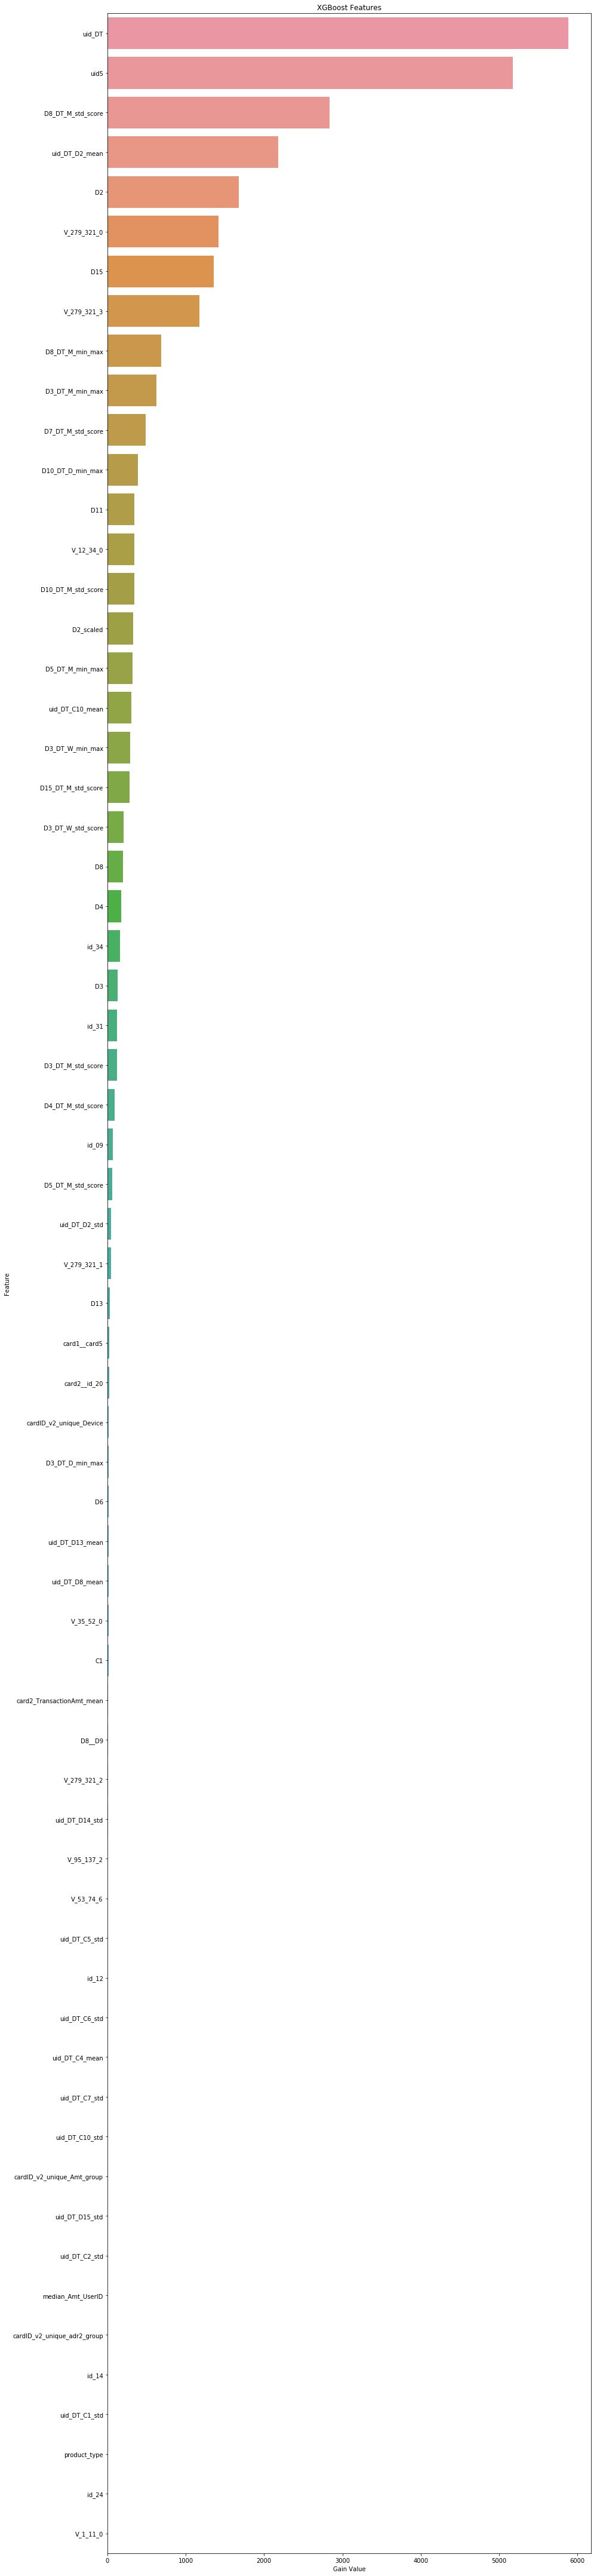

In [0]:
plt.figure(figsize=(14,60))
sns.barplot(x="Gain Value", y="Feature", data=feature_importance.sort_values(by="Gain Value", ascending=False))
plt.title('XGBoost Features')
plt.tight_layout()
#plt.savefig('../content/gdrive/My Drive/IEEE fraud Kaggle 2019/xgb_output/feature_imp_adversarial.png')

In [0]:
feature_importance = feature_importance.sort_values(by='Gain Value',ascending=False)
feature_importance

,Feature,Gain Value
0,V_53_74_5,12179.464079
76,V_53_74_11,2504.347158
3,V_1_11_1,1958.382901
12,M7,1947.849311
1,uid_DT_D13_mean,1878.030877
40,uid_DT_D7_std,1775.943797
55,uid_DT_D12_mean,1773.013740
9,id_31,1767.620605
87,V_75_94_0,1744.897783
88,V_322_339_1,1611.673023
